<a href="https://colab.research.google.com/github/Sadiya-Afroz/23455777-Sadiya-Afroz/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

<!-- ## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages. -->


In [16]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install pyinputplus
!pip install matplotlib
!pip install requests
!pip install ollama

In [19]:
import json
import re
import os
import requests
from datetime import datetime

## 📦 Setup and Configuration
Import required packages and setup environment.

In [21]:
import matplotlib.pyplot as plt

import pyinputplus as pyip


from ollama import Client

In [22]:
os.environ['OLLAMA_SERVER'] = 'http://ollama.serveur.au/'

#### Run this to enter ollama API key manually

In [23]:
# api_key = pyip.inputStr("Enter your Ollama API key: ")
# os.environ['OLLAMA_API_KEY'] = api_key

## 🌤️ Weather Data Functions

In [24]:
def get_weather_data(location, forecast_days=5):

    """
    Retrieve weather data for a specified location using the wttr.in API.

    Args:
        location (str): City or location name (e.g. "Perth")
        forecast_days (int): Number of days to forecast (1–5)

    Returns:
        dict: Weather data including current conditions and forecast
    """

    try:
        url = f"https://wttr.in/{location}?format=j1"

        response = requests.get(url)
        response.raise_for_status()

        weather = response.json()

        if not weather:
            print("WARNING: No data returned. Check location spelling or internet connection.")
            return None

        weather['location'] = weather.get("nearest_area", [{}])[0].get("areaName", [{}])[0].get("value", location)

        current_condition = weather.get("current_condition", [])
        if not current_condition:
            print("WARNING: No current condition data found. Check location spelling or internet connection.")
            return None

        weather['current_condition'] = current_condition[0]

        if len(current_condition) > 0:
            weather['current_condition'] = current_condition[0]

        forecast = weather.get("weather", [])[:forecast_days]
        if not forecast:
            print("WARNING: No forecast data found. Check location spelling or internet connection.")
            return None

        if "weather" in weather:
            weather["forecast"] = weather["weather"]
            del weather["weather"]

        return weather

    except requests.exceptions.RequestException as e:
        print("ERROR: Network or connection error:", e)
        return None

    except Exception as e:
        print("ERROR: Error fetching weather data:", e)
        return None

## 📊 Visualisation Functions

In [25]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a line chart showing the average temperature for each forecast day.

    Args:
        weather_data (dict): The weather data returned by get_weather_data()
        output_type (str): 'display' to show in notebook, 'figure' to return the chart object

    Returns:
        If output_type == 'figure', returns the matplotlib Figure object.
        Otherwise, displays the chart directly in the notebook.
    """

    days = weather_data.get("forecast", [])
    if not days:
        print("[ERROR] No forecast data available.")
        return

    dates = []
    temps = []

    for day in days:
        date = day.get("date", "N/A")
        avg_temp = day.get("avgtempC") or day.get("avgtemp", 0)
        try:
            avg_temp = int(avg_temp)
        except Exception:
            avg_temp = 0
        dates.append(date)
        temps.append(avg_temp)

    if not any(temps):
        print("Temperature data missing or zero — check your data source.")
        return

    fig = plt.figure()

    plt.plot(dates, temps, marker='o', color='orange', linewidth=2)
    plt.title("Average Temperature Over Time (°C)")

    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)

    if output_type == 'figure':
        return fig
    else:
        plt.show()

In [26]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create a bar chart showing the chance of rain for each forecast day.

    Args:
        weather_data (dict): The weather data returned by get_weather_data()
        output_type (str): 'display' to show in notebook, 'figure' to return the chart object

    Returns:
        If output_type == 'figure', returns the matplotlib Figure object.
        Otherwise, displays the chart directly in the notebook.
    """

    days = weather_data.get("forecast", [])
    if not days:
        print("[WARNING] No forecast data available.")
        return

    dates = []
    rain_chances = []

    for day in days:
        date = day.get("date", "N/A")

        hourly = day.get("hourly", [])
        if not hourly:
            rain_chance = 0
        else:
            # average over hours
            rain_chance = sum(int(hour.get("chanceofrain") or hour.get("chance_of_rain") or 0) for hour in hourly) / len(hourly)
        date_formatted = datetime.strptime(date, "%Y-%m-%d").date()
        dates.append(date_formatted)
        rain_chances.append(rain_chance)

    if not any(rain_chances):
        print("Warning: No precipitation data found — check your data structure or API mode.")
        return

    fig = plt.figure()
    plt.bar(dates, rain_chances, color='skyblue')
    plt.title("Chance of Rain (%) (Hourly Data Averaged)")
    plt.xlabel("Date")
    plt.ylabel("Chance (%)")
    plt.ylim(0, 100)

    if output_type == 'figure':
        return fig
    else:
        plt.show()

In [27]:
def create_humidity_visualisation(weather_data, output_type='display'):
    """
    Create a bar chart showing the chance of rain for each forecast day.

    Args:
        weather_data (dict): The weather data returned by get_weather_data()
        output_type (str): 'display' to show in notebook, 'figure' to return the chart object
    Returns:
        If output_type == 'figure', returns the matplotlib Figure object.
        Otherwise, displays the chart directly in the notebook.
    """

    days = weather_data.get("forecast", [])
    if not days:
        print("[WARNING] No forecast data available.")
        return

    dates = []
    humidity = []

    for day in days:
        date = day.get("date", "N/A")

        hourly = day.get("hourly", [])
        if not hourly:
            humidity_value = 0
        else:
            # average over hours
            humidity_value = sum(int(hour.get("humidity") or hour.get("humidity") or 0) for hour in hourly) / len(hourly)
        date_formatted = datetime.strptime(date, "%Y-%m-%d").date()
        dates.append(date_formatted)
        humidity.append(humidity_value)

    if not any(humidity):
        print("Warning: No humidity data found — check your data structure or API mode.")
        return
    fig = plt.figure()
    plt.bar(dates, humidity, color='skyblue')
    plt.title("Humidity (%) (Hourly Data Average)")
    plt.xlabel("Date")
    plt.ylabel("Humidity (%)")
    plt.ylim(0, 100)

    if output_type == 'figure':
        return fig
    else:
        plt.show()

## 🤖 Natural Language Processing

In [28]:
def get_response(prompt):
    """
    Get a response from ollama server chat model.

    Args:
        prompt (str): The input prompt to send to the model.

    Returns:
        str: The model's response.
    """
    try:
        client = Client( host="https://ollama.com",
            headers={
                'Authorization': 'Bearer ' + os.environ.get('OLLAMA_API_KEY')
            }
        )

        response = client.chat(model='gpt-oss:120b', messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ])
    except Exception as e:
        print("Error getting response from model:", e)
        return ""

    return response['message']['content']

In [29]:
def safe_json_loads(json_string):
    """
    Safely load a JSON string, returning an empty dict on failure.

    Args:
        json_string (str): The JSON string to parse.
    Returns:
        dict: The parsed JSON object, or empty dict on failure.
    """

    match = re.search(r'\{.*\}', json_string, re.DOTALL)
    if match:
        json_string = match.group(0)
    try:
        return json.loads(json_string)
    except json.JSONDecodeError:
        print("Error: Failed to parse JSON from model response.")
        return {}


safe_json_loads('``{"location": "Sydney", "time_period": "tomorrow", "weather_attribute": "rain"}')

{'location': 'Sydney', 'time_period': 'tomorrow', 'weather_attribute': 'rain'}

In [30]:
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question (e.g., "Will it rain tomorrow in Sydney?")

    Returns:
        dict: Extracted information including location, time period, and weather attribute.
              Example: {"topic": "rain", "location": "Sydney", "time": "tomorrow"}
    """

    prompt = f"""
        Extract location, time period, and weather attribute from
        the following question:  {question}
        CRITICAL: Return the result as a JSON
        object with keys
        - 'location': the specified location, for example Perth, London, Paris (string, Perth is none)
        - 'time_period': the time period for example, 'today', 'tomorrow', 'next week' (string, today is none)
        - 'weather_attribute': the weather attribute for example, 'temperature', 'precipitation' (string, general is none)
    """

    reponse = get_response(prompt)
    json = safe_json_loads(reponse)

    return json

In [31]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data (from parse_weather_question)
        weather_data (dict): Weather data (from get_weather_data)

    Returns:
        str: Human-readable weather answer
    """

    location = parsed_question.get("location", "the specified location")
    time_period = parsed_question.get("time_period", "the specified time period")
    weather_attribute = parsed_question.get("weather_attribute", "general")

    prompt = f"""
        Using the following weather data, provide a concise answer to the user's question.
        Location: {location}
        Time Period: {time_period}
        Weather Attribute: {weather_attribute}

        Weather Data: {json.dumps(weather_data, indent=2)}

        Answer the question in a friendly and informative manner,
        it should be a single paragraph avoiding bullet pointing or lsiting,
        only the data that is necessary according to the weather attribute requested.
        If data is missing, indicate that politely.
    """

    response = get_response(prompt)
    return response

## 🧭 User Interface

In [32]:
def show_current_weather_data(weather_data):
    """
    Fetch and display current weather data for a specified city.

    Args:
        city (str): The city name to fetch weather data for.
    """

    if not weather_data:
        print("Could not retrieve weather data.")
        return

    current = weather_data.get("current_condition", {})
    if not current:
        print("No current weather data available.")
        return

    temperature = current.get("temp_C") or current.get("temp_F") or "N/A"
    humidity = current.get("humidity", "N/A")
    description = current.get("weatherDesc", [{}])[0].get("value", "N/A")

    print(f"Current weather in {weather_data['location']}:")
    print(f"Temperature: {temperature}°C")
    print(f"Humidity: {humidity}%")
    print(f"Description: {description}")


Enter a city name (e.g., Perth, Sydney): Dhaka


Current weather in Dhaka:
Temperature: 30°C
Humidity: 49%
Description: Clear

Current Weather Summary:
Error getting response from model: can only concatenate str (not "NoneType") to str


Generating charts...


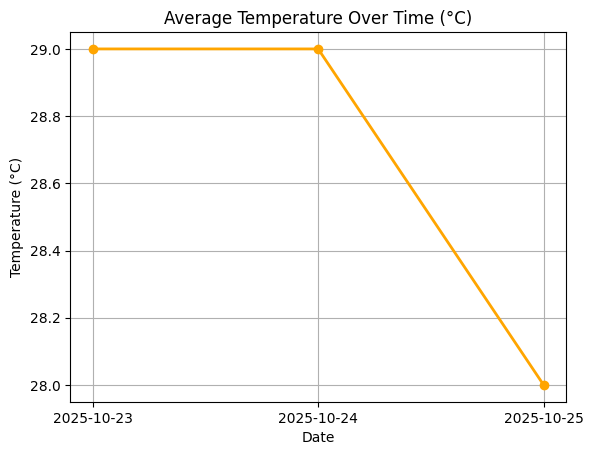

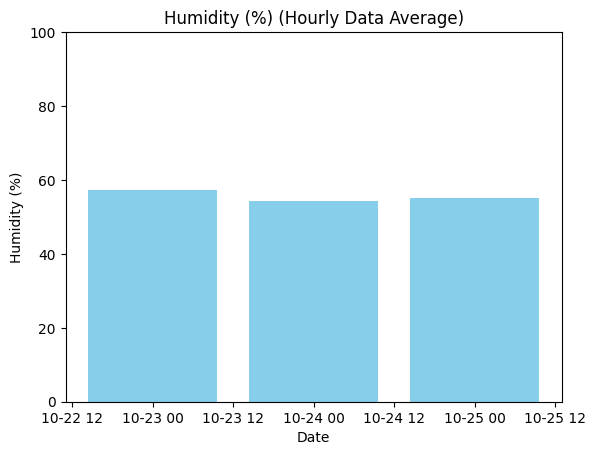

In [33]:
def run_all_at_once():
    """
    Run one full weather check session:
    - Ask for a city
    - Display current summary
    - Show temperature and rain charts
    - Answer one natural language question
    """

    city = pyip.inputStr("Enter a city name (e.g., Perth, Sydney): ")

    weather_data = get_weather_data(city)

    print("\n")
    show_current_weather_data(weather_data)

    if not weather_data:
        print("[WARNING] Could not fetch data. Please try again.")
        return

    print("\nCurrent Weather Summary:")
    print(generate_weather_response({"topic": "general_overview"}, weather_data))

    print("\nGenerating charts...")
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)
    create_humidity_visualisation(weather_data)

run_all_at_once()

## 🧩 Main Application Logic

In [34]:

def main_menu():
    """
    A simple text-based main menu using PyInputPlus.
    """

    print("🌦️ Welcome to WeatherWise!")

    while True:
        choice = pyip.inputMenu(
            ["Current weather data", "Ask about weather", "Visualizations", "Run all together" ,"Quit"],
            numbered=True,
            prompt="\nMain Menu - Choose an option:\n"
        )

        if choice == "Current weather data":
            city = pyip.inputStr("Enter a city name (e.g., Perth, Sydney): ")
            weather_data = get_weather_data(city)
            show_current_weather_data(weather_data)

        elif choice == "Ask about weather":
            question = pyip.inputStr("\nAsk a weather question (e.g., Will it rain tomorrow in Perth?): ")
            parsed = parse_weather_question(question)
            weather_data = get_weather_data(parsed.get("location", 'london'))
            print("\n🤖 Answer:")
            print(generate_weather_response(parsed, weather_data))

        elif choice == "Visualizations":
            city = pyip.inputStr("Enter a city name (e.g., Perth, Sydney): ")

            while True:
                v_type = pyip.inputMenu(
                    ["Temperature Chart", "Precipitation Chart", "Humidity Chart", "Both Charts", 'Exit to Main Menu'],
                    numbered=True,
                    prompt="\nChoose a visualization type:\n"
                )

                if v_type == "Temperature Chart":
                    print("Getting weather data...")
                    weather_data = get_weather_data(city)
                    print("\nGenerating Temperature Chart...")
                    create_temperature_visualisation(weather_data)

                elif v_type == "Precipitation Chart":
                    print("Getting weather data...")
                    weather_data = get_weather_data(city)
                    print("\nGenerating Precipitation Chart...")
                    create_precipitation_visualisation(weather_data)

                elif v_type == "Humidity Chart":
                    print("Getting weather data...")
                    weather_data = get_weather_data(city)
                    print("\nGenerating Humidity Chart...")
                    create_humidity_visualisation(weather_data)

                elif v_type == "Both Charts":
                    print("Getting weather data...")
                    weather_data = get_weather_data(city)
                    print("\nGenerating Both Charts...")
                    create_temperature_visualisation(weather_data)
                    create_precipitation_visualisation(weather_data)
                    create_humidity_visualisation(weather_data)

                elif v_type == "Exit to Main Menu":
                    break

                else:
                    print("NOT A VALID OPTION")
                    break

        elif choice == "Run all together":
            run_all_at_once()

        elif choice == "Quit":
            print("Goodbye!..")
            break
        else:
            break

In [35]:
def main_app():
    """
    Main function to run the weather application.
    - Fetch and display current weather data
    - Generate visualizations
    - Answer natural language questions
    """

    main_menu()
main_app()

🌦️ Welcome to WeatherWise!

Main Menu - Choose an option:
1. Current weather data
2. Ask about weather
3. Visualizations
4. Run all together
5. Quit
1
Enter a city name (e.g., Perth, Sydney): Tokyo
Current weather in Shikinejima:
Temperature: 18°C
Humidity: 76%
Description: Patchy rain nearby

Main Menu - Choose an option:
1. Current weather data
2. Ask about weather
3. Visualizations
4. Run all together
5. Quit
5
Goodbye!..


## 🧪 Testing and Examples

In [36]:
# Include sample input/output for each function
def hands_on_ai_example():
    """
    Example of using Hands-On AI to generate a weather response.
    """
    prompt = (
        "The current weather in Perth is 25°C with light rain. "
        "Humidity is 60% and wind speed is 15 km/h. "
        "Will it rain tomorrow?"
    )

    response = get_response(prompt)
    print("🤖 Hands-On AI Response:")
    print(response)
print(hands_on_ai_example())

Error getting response from model: can only concatenate str (not "NoneType") to str
🤖 Hands-On AI Response:

None


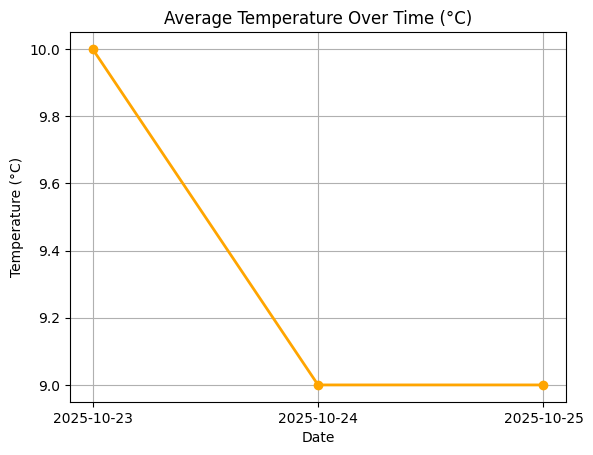

In [37]:
def temperature_visualization_example():
    w = get_weather_data("london")
    create_temperature_visualisation(w, 'display')

temperature_visualization_example()

In [38]:
# test getting weather data
print(parse_weather_question("Will it rain tomorrow in Sydney?"))

Error getting response from model: can only concatenate str (not "NoneType") to str
Error: Failed to parse JSON from model response.
{}


In [39]:
def checking_current_weather_data_example():
    w = get_weather_data("sydney")
    show_current_weather_data(w)
checking_current_weather_data_example()

Current weather in Sydney:
Temperature: 19°C
Humidity: 68%
Description: Overcast


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.